In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("src/")
import operator
from importlib import reload
import src.preprocessing.data_loading as data_loading
import models.experiment as experiment
import models.rnn as rnn
import analysis.umap_analysis as umap
import analysis.scatter_plots as scatter_plots
import analysis.evaluation as evaluation
from preprocessing.X_representation import RAA_to_seq
from preprocessing.X_representation_utils import initialize_Proc2Vec_embeddings
from utils.utils import find_3mer
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from analysis.heatmap_analysis import generate_heatmap


2023-03-03 10:58:45.417471: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-03 10:59:03.760672: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/envs/ml_phage/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Train/Load MDM2 vs. 12ca5 Model



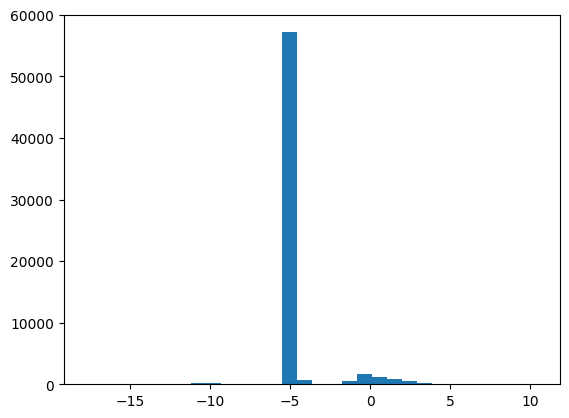

ER Test
	 accuracy:  0.9536610143002267
	 precision:  0.5130434782608696
	 recall:  0.09899328859060402
	 # neg predictions:  12682
	 # pos predictions:  115


array([[12145,    56],
       [  537,    59]])

In [34]:
ca5_er_lib = data_loading.read_data_and_preprocess(datafile="12ca5_merged_ER.csv")
ca5_X, ca5_y_classes, ca5_y_raw, ca5_peptides, FEATURE_LIST = data_loading.build_er_dataset(ca5_er_lib)
plt.hist(ca5_y_raw, bins=30)
plt.show()
from sklearn import metrics
(
    (
        ca5_X_train,
        ca5_X_test,
        ca5_y_train,
        ca5_y_test,
        ca5_peptides_train,
        ca5_peptides_test,
        ca5_y_raw_train,
        ca5_y_raw__test,
    ),
    results,
) = experiment.BinaryClassificationExperiment().run_adhoc_experiment(
    ca5_X,
    ca5_y_classes,
    rnn.BinaryClassificationRNN,
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    load_trained_model=True,
    model_save_name='ER_12ca5_bilstm.h5',
    other_datasets=[
        ca5_peptides,
        ca5_y_raw,
    ],
)
ca5_model = results.trained_model
ca5_y_pred_raw = ca5_model(ca5_X_test)
ca5_y_pred = ca5_y_pred_raw > 0.5

print("12ca5 ER Test")
tn, fp, fn, tp = confusion_matrix(ca5_y_test, ca5_y_pred).ravel()
print('\t accuracy: ', metrics.accuracy_score(ca5_y_test, ca5_y_pred))
print('\t precision: ', metrics.precision_score(ca5_y_test, ca5_y_pred))
print('\t recall: ', metrics.recall_score(ca5_y_test, ca5_y_pred))
print('\t # neg predictions: ', tn + fn)
print('\t # pos predictions: ', tp + fp)
confusion_matrix(ca5_y_test, ca5_y_pred)


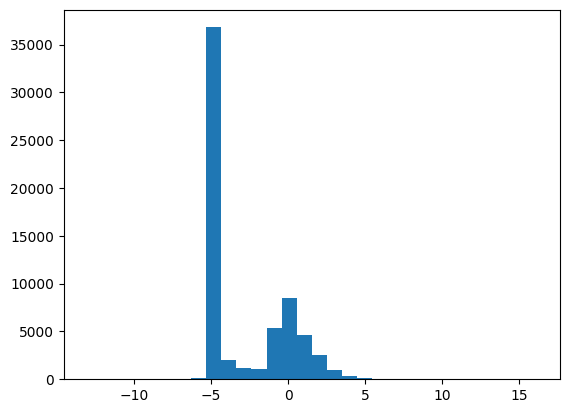

Epoch 1/50
400/400 [==============================] - 10s 7ms/step - loss: 0.3261 - accuracy: 0.9015 - recall_3: 0.0000e+00 - precision_3: 0.0000e+00 - lr: 0.0010
Epoch 2/50
400/400 [==============================] - 3s 8ms/step - loss: 0.3010 - accuracy: 0.9015 - recall_3: 0.0000e+00 - precision_3: 0.0000e+00 - lr: 0.0010
Epoch 3/50
400/400 [==============================] - 3s 8ms/step - loss: 0.2938 - accuracy: 0.9015 - recall_3: 0.0000e+00 - precision_3: 0.0000e+00 - lr: 0.0010
Epoch 4/50
400/400 [==============================] - 3s 8ms/step - loss: 0.2912 - accuracy: 0.9015 - recall_3: 0.0000e+00 - precision_3: 0.0000e+00 - lr: 0.0010
Epoch 5/50
400/400 [==============================] - 3s 9ms/step - loss: 0.2897 - accuracy: 0.9015 - recall_3: 0.0000e+00 - precision_3: 0.0000e+00 - lr: 0.0010
Epoch 6/50
400/400 [==============================] - 4s 9ms/step - loss: 0.2884 - accuracy: 0.9015 - recall_3: 0.0000e+00 - precision_3: 0.0000e+00 - lr: 9.0484e-04
Epoch 7/50
400/400 [===

/opt/anaconda3/envs/ml_phage/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[11523,     0],
       [ 1274,     0]])

In [38]:
mdm2_er_lib = data_loading.read_data_and_preprocess(datafile="MDM2_merged_ER.csv")
(
    mdm2_X,
    mdm2_y_classes,
    mdm2_y_raw,
    mdm2_peptides,
    FEATURE_LIST,
) = data_loading.build_er_dataset(mdm2_er_lib, er_threshold=1)
plt.hist(mdm2_y_raw, bins=30)
plt.show()
from sklearn import metrics

(
    (
        mdm2_X_train,
        mdm2_X_test,
        mdm2_y_train,
        mdm2_y_test,
        mdm2_peptides_train,
        mdm2_peptides_test,
        mdm2_y_raw_train,
        mdm2_y_raw__test,
    ),
    results,
) = experiment.BinaryClassificationExperiment().run_adhoc_experiment(
    mdm2_X,
    mdm2_y_classes,
    rnn.BinaryClassificationRNN,
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    load_trained_model=True,
    model_save_name="ER_mdm2_regression",#"ER_mdm2_bilstm.h5",
    other_datasets=[
        mdm2_peptides,
        mdm2_y_raw,
    ],
)
mdm2_model = results.trained_model
mdm2_y_pred_raw = mdm2_model(mdm2_X_test)
mdm2_y_pred = mdm2_y_pred_raw > 0.5

print("MDM2 ER Test")
tn, fp, fn, tp = confusion_matrix(mdm2_y_test, mdm2_y_pred).ravel()
print("\t accuracy: ", metrics.accuracy_score(mdm2_y_test, mdm2_y_pred))
print("\t precision: ", metrics.precision_score(mdm2_y_test, mdm2_y_pred))
print("\t recall: ", metrics.recall_score(mdm2_y_test, mdm2_y_pred))
print("\t # neg predictions: ", tn + fn)
print("\t # pos predictions: ", tp + fp)
confusion_matrix(mdm2_y_test, mdm2_y_pred)


## Hit Rate by BiLSTM Model Confidence Ranking 

KeyboardInterrupt: 

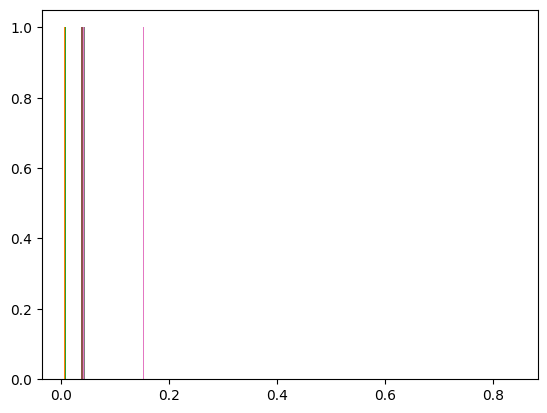

In [45]:
plt.hist(ca5_y_pred_raw,bins=30)

MDM2 area under curve:  13.85967575077354
normalized MDM2 area under curve:  0.02771935150154708
12ca5 area under curve:  7.122114953291106
normalized 12ca5 area under curve:  0.014244229906582213


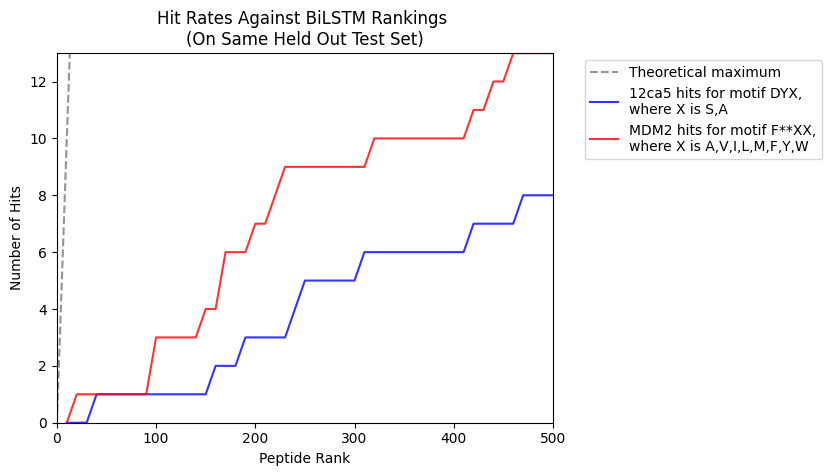

drop C
max is  48.0
drop C
max is  44.0


<AxesSubplot: >

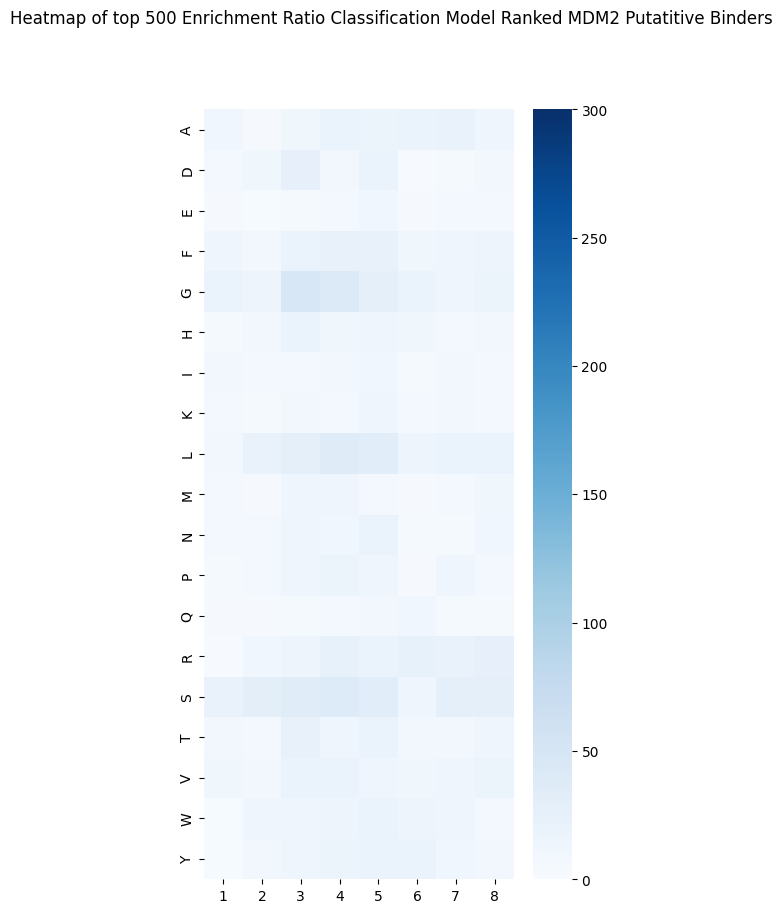

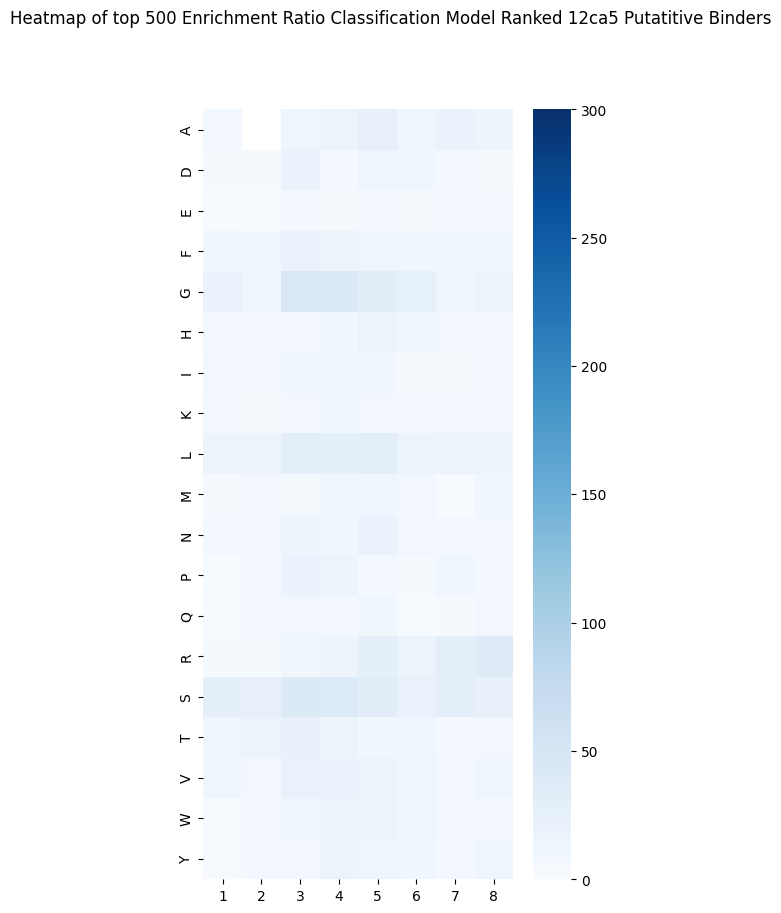

In [42]:
from analysis.hit_rate_analysis import (
    plot_ratio_by_ranking,
    sort_peptides_by_model_ranking,
)
ca5_ordering = ca5_y_pred_raw.numpy()
mdm2_ordering = mdm2_y_pred_raw.numpy()

plot_ratio_by_ranking(
    peptides=mdm2_peptides,
    ca5_y_ranking=ca5_ordering,
    mdm2_y_ranking=mdm2_ordering,
    title="Hit Rates Against Enrichment Ratio BiLSTM Rankings \n(On Same Held Out Test Set)",
    plot_theoretical_maximums=True,
)

generate_heatmap(
    sort_peptides_by_model_ranking(mdm2_peptides, mdm2_ordering)[:500],
    title="Heatmap of top 500 Enrichment Ratio Classification Model Ranked MDM2 Putatitive Binders",
)
generate_heatmap(
    sort_peptides_by_model_ranking(mdm2_peptides, ca5_ordering)[:500],
    title="Heatmap of top 500 Enrichment Ratio Classification Model Ranked 12ca5 Putatitive Binders",
)


## Hit Rate by Volcano Plot Ground Truth

Fontconfig warning: ignoring UTF-8: not a valid region tag
Matplotlib is building the font cache; this may take a moment.


MDM2 area under curve:  128.30734508661922
normalized MDM2 area under curve:  0.25661469017323846
12ca5 area under curve:  109.41273161356146
normalized 12ca5 area under curve:  0.21882546322712293


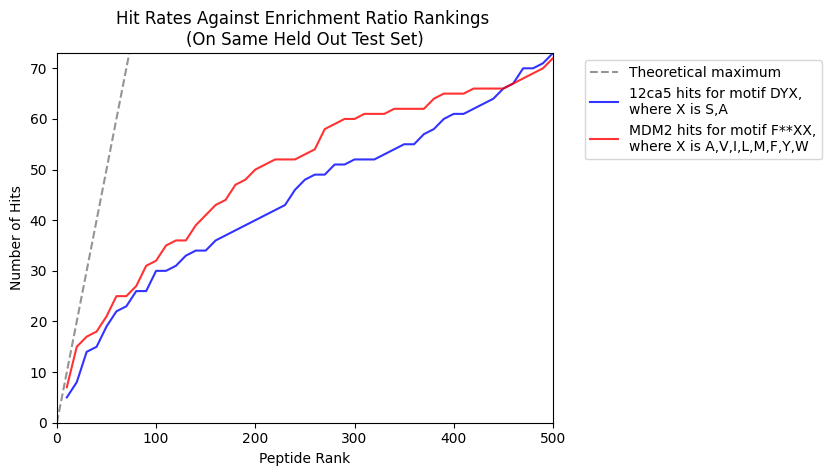

drop C
max is  95.0
drop C
max is  95.0


<AxesSubplot: >

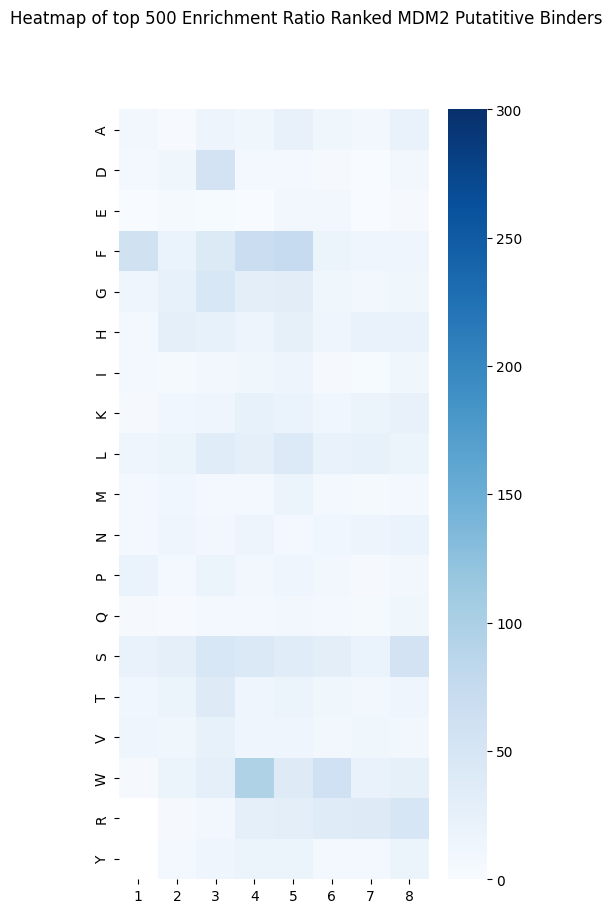

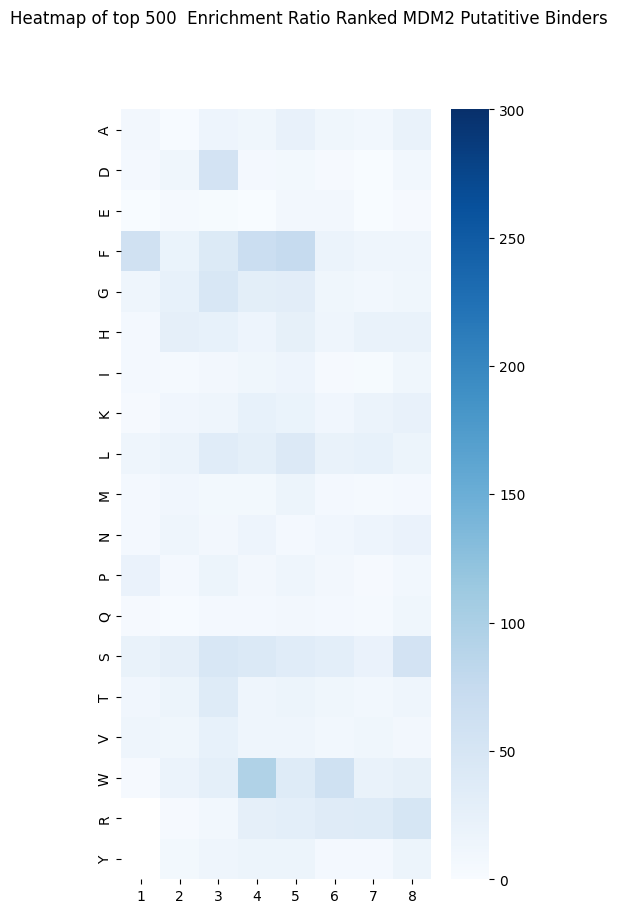

In [43]:
from analysis.hit_rate_analysis import plot_ratio_by_ranking
from analysis.create_weblogos import save_web_logo_alignment

plot_ratio_by_ranking(
    peptides=mdm2_peptides,
    ca5_y_ranking=ca5_y_raw,
    mdm2_y_ranking=mdm2_y_raw,
    title="Hit Rates Against Enrichment Ratio Rankings \n(On Same Held Out Test Set)",
    plot_theoretical_maximums=True,
)

sorted_volcano_mdm2_peptides = sort_peptides_by_model_ranking(mdm2_peptides, mdm2_y_raw)
generate_heatmap(
    sort_peptides_by_model_ranking(mdm2_peptides, mdm2_y_raw)[:500],
    title="Heatmap of top 500 Enrichment Ratio Ranked MDM2 Putatitive Binders",
)
generate_heatmap(
    sort_peptides_by_model_ranking(mdm2_peptides, mdm2_y_raw)[:500],
    title="Heatmap of top 500  Enrichment Ratio Ranked MDM2 Putatitive Binders",
)


Fontconfig warning: ignoring UTF-8: not a valid region tag

MUSCLE v3.8.31 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.

_example 500 seqs, max length 12, avg  length 8
00:00:00      3 MB(0%)  Iter   1  100.00%  K-mer dist pass 1
00:00:00      3 MB(0%)  Iter   1  100.00%  K-mer dist pass 2
00:00:00      9 MB(0%)  Iter   1  100.00%  Align node       
00:00:00      9 MB(0%)  Iter   1  100.00%  Root alignment
/opt/anaconda3/envs/ml_phage/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


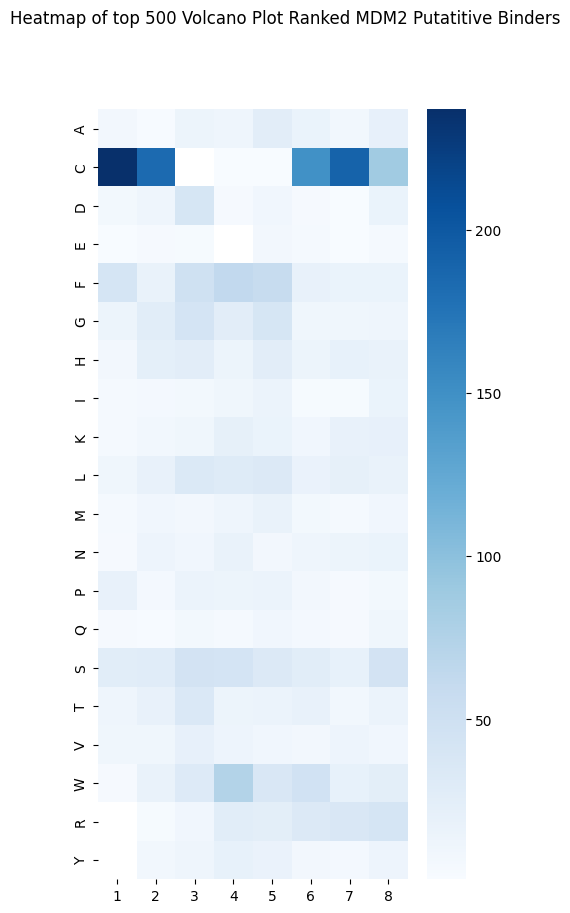

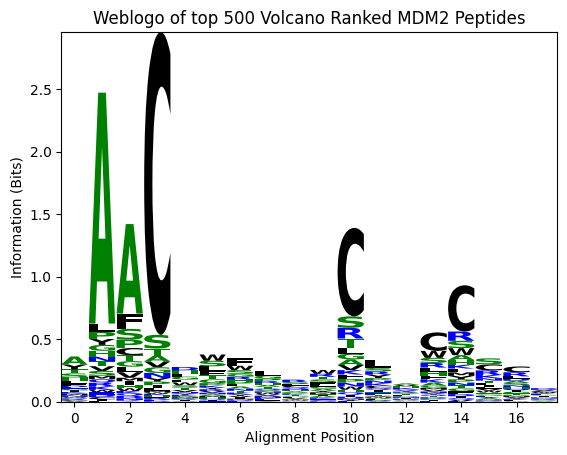

In [11]:
# from analysis.create_weblogos import save_web_logo_alignment

# sorted_volcano_mdm2_peptides = sort_peptides_by_model_ranking(
#     mdm2_peptides, mdm2_y_raw
# )
# generate_heatmap(
#     sorted_mdm2_peptides[:500], title="Heatmap of top 500 Volcano Plot Ranked MDM2 Putatitive Binders"
# )
# save_web_logo_alignment(
#     web_logo_name=None,
#     seqs=sorted_mdm2_peptides[:500],
#     align=True,
#     axis=None,
#     to_type="information",
#     title='Weblogo of top 500 Volcano Ranked MDM2 Peptides'
# )
